# Optimisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from PortfolioToolboxQP.PortfolioToolboxQP.Qp_Solver import qp_solver_cpp as solve

Il faut remplir le code suivant avec ce qu'on a calculé dans les autres fichiers. Faut juste faire attention à ce qu'on est les mêmes colonnes pour tous sinon on va avoir des problèmes de dimensions.

## Imports

In [3]:
sigma = np.load("data/cov_matrix_sigma.npy")
CI = pd.read_csv("data/CarbonIntensity.csv")
CI0 = CI["CARBON_EMISSIONS_SCOPE_12_FY23"].values.reshape(-1, 1)
Green = CI["CT_TOTAL_MAX_REV"].values.reshape(-1, 1)
bench = (CI["Weight"].values / CI["Weight"].sum()).reshape(-1, 1)


## Optimisation

### Problème à écrire

J'ai pris le problème le plus simple avec le moins de contrainte (min 1/2(x-b)Tsigma(x-b) avec comme contraintes la carbone intensity, et le bail C0 des long only constraints [x entre 0 et 1 et qui se somme à 1])

x is what we want : here the relative weights on the differents firms. The following Y is what we call "x-b". 
 We have to add the benchmark at the end

                            minimize 0.5*Y.T@Q@Y + p@Y under constraints AY = B and GY <= h and  lb <= Y <= ub
    
    all parameters are ndarray

    Q: sigma for us
    p: 0

    CI*(X=Y+b) <= (1-R)CI_0*b donc CI*Y <= (1-R)*CI_0*b - CI*b
    G*X >= (1+g)G_0*b 
    CM*X <= CMstar
    G: Matrix of inequalty constraints 
    h: Vector of inequality constraints 

    1.T(Y+b)=1 donc 1TY = - 1Tb + 1
    A: Matrix of equality constraints → 1T
    b: Vector of equality constraints → -1Tb + 1
    
    lb: Lower bound for Y : for x : 0
    ub: Upper bound for Y : for x : 1

    return: optimal vector if found : Y=X-b

### Calcul du réduction rate 

In [4]:
def decarbonization_pathway(t0, t, Rm, dR):
    """
    Compute the decarbonization budget with equation (1).

    param t0: base year
    param t: year index
    param Rm: minimum carbon intensity reduction
    param dR: year-to-year self decarbonization on average per annum
    """
    return 1 - (1 - dR) ** (t - t0) * (1 - Rm)

### Optimisation avec pour contraintes le carbon momentum, la greenness et les émissions carbone

In [8]:
t0, t = 2023, 2050
times = np.arange(t0, t + 1)
# CTB label: Rm=0.3 dR=0.07
ctb_label = decarbonization_pathway(t0, times, 0.3, 0.07)
# PAB label: Rm=0.5 dr=0.07
pab_label = decarbonization_pathway(t0, times, 0.5, 0.07)
# Greenness evolution
g = 1
# CM* = 7%
CMstar = np.zeros(1)
CMstar[0]=-0.07

x_list_green = []
te_green = []
R_ = pab_label

for year in range(len(R_)):
    R = R_[year]
    ye = 23+year
    print(ye)
    column_CE = "CARBON_EMISSIONS_SCOPE_12_FY"+str(ye)
    CI_year = CI[column_CE].values.reshape(-1, 1)
    column_CM = "CARBON_MOMENTUM_SCOPE_12_FY"+str(ye)
    CM_year = CI[column_CM].values.reshape(-1, 1)
    CI_year[CI_year < 0] = 0
    y = solve(
        Q = sigma,
        p = None,
        G = np.concatenate((CI_year, -Green, CM_year), axis=1).T,#CI0 -Gt CM
        h = np.concatenate(((1 - R)*CI0.T@bench-CI_year.T@bench,-g*Green.T@bench, CMstar-CM_year.T@bench),axis=0),# (1-R)CI0b-CItb   -(1+g)G0b-Gtb    CM*-CMb
        A = np.ones((bench.shape[0],1)).T,
        b = -np.ones(bench.shape).T @ bench + 1,
        lb = - bench,
        ub =np.ones(bench.shape) - bench,
    )
    y = y[:,np.newaxis]
    x = y + bench
    x_list_green.append(x)
    name_col = "Weight_G_FY"+str(ye)
    CI[name_col] = x
    tracking_error = 0.5 * y.T @ sigma @ y
    te_green.append(tracking_error)

23


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


24


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


25


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


26


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


27


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


28


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


29


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


30


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


31


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


32


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


33


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


34


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


35


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


36


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


37


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


38


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


39


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


40


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


41


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


42


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


43


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


44


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


45


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


46


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


47


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


48


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


49


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


50


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


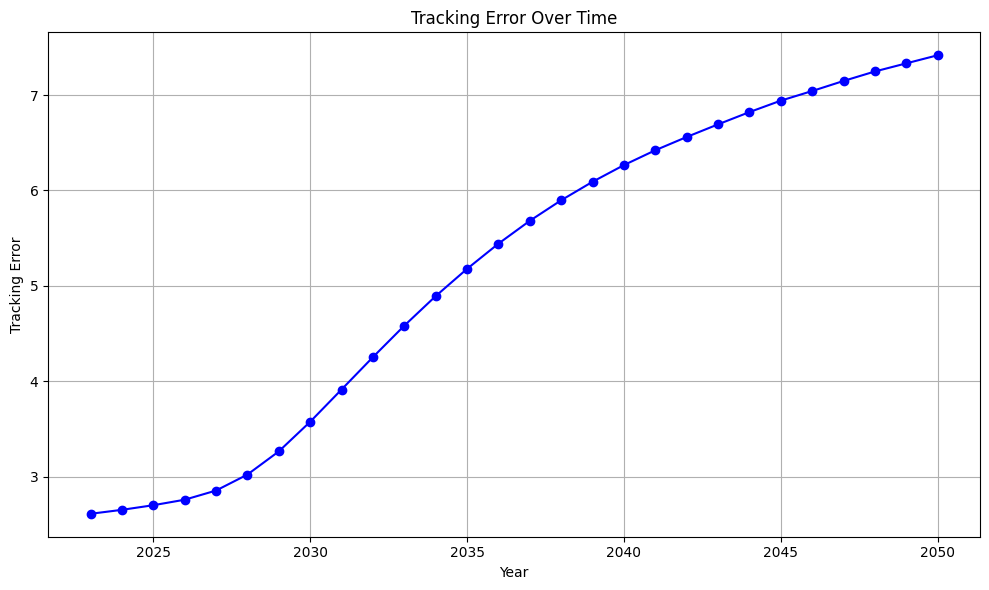

In [9]:
# Convert the list of tracking errors to a numpy array for easier manipulation
te_array_green = [np.sqrt(te_green[i][0][0])*1e4 for i in range(len(te_green))]

# Plot the tracking error over time
plt.figure(figsize=(10, 6))
plt.plot(times, te_array_green, marker='o', linestyle='-', color='b')
plt.title('Tracking Error Over Time')
plt.xlabel('Year')
plt.ylabel('Tracking Error')
plt.grid(True)
plt.tight_layout()
plt.show()

## Evolution des poids dans le portefeuille

### Poids avec pour contraintes le carbon momentum, la greenness et les émissions carbone

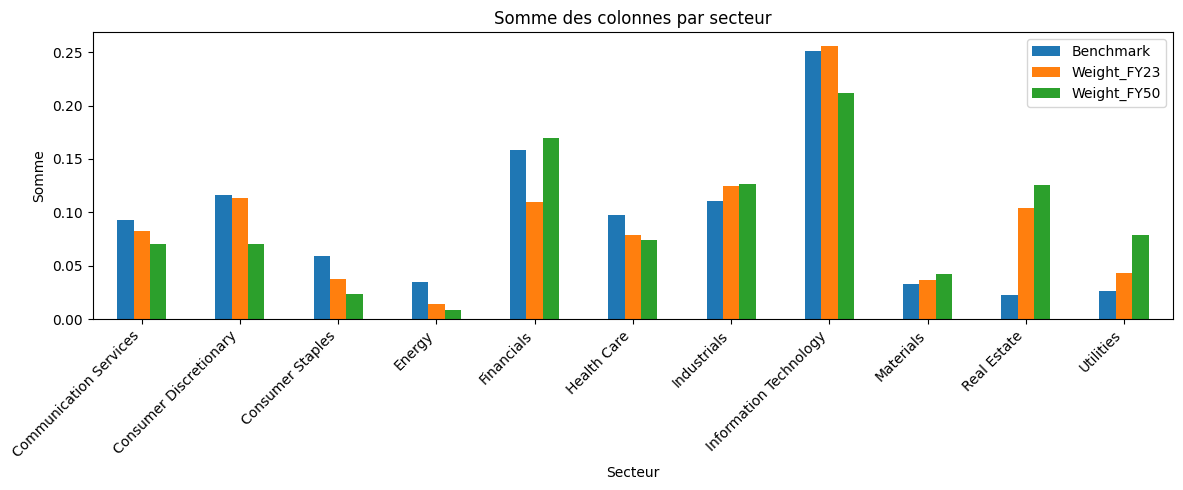

In [17]:
CI["benchmark"] = bench
grouped = CI.groupby("GICS_SECTOR")[[ "benchmark","Weight_G_FY23","Weight_G_FY50"]].sum()

# Tracer l'histogramme
grouped.plot(
    kind="bar",
    figsize=(12, 5),
    stacked=False,  # Changez en True pour un histogramme empilé
)
plt.title("Somme des colonnes par secteur")
plt.xlabel("Secteur")
plt.ylabel("Somme")
plt.xticks(rotation=45, ha="right")  # Rotation des étiquettes pour lisibilité
plt.legend(["Benchmark","Weight_FY23", "Weight_FY50"], loc="upper right")  # Légende personnalisée
plt.tight_layout()
plt.show()

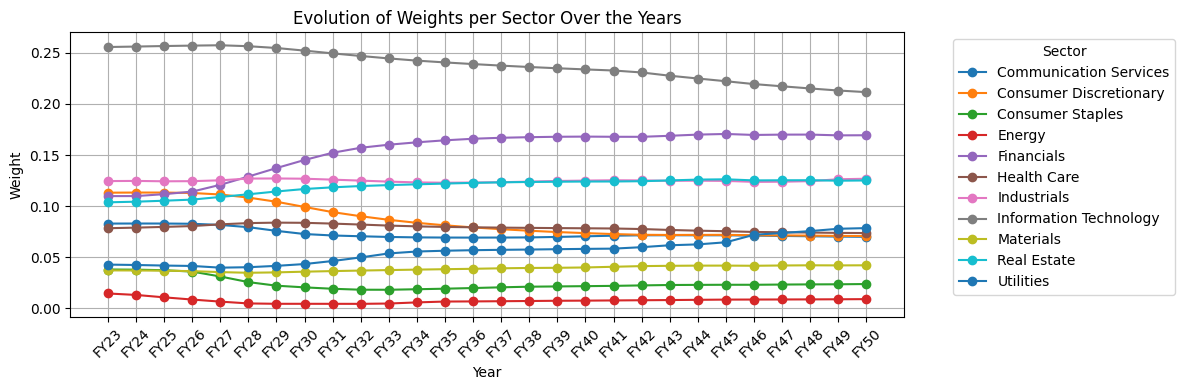

In [18]:
# Extract the columns related to weights over the years
weight_columns = [col for col in CI.columns if col.startswith('Weight_G_FY')]

# Group by sector and sum the weights for each year
sector_weights = CI.groupby('GICS_SECTOR')[weight_columns].sum()

# Plot the evolution of weights per sector over the years
sector_weights.T.plot(figsize=(12, 4), marker='o')
plt.title('Evolution of Weights per Sector Over the Years')
plt.xlabel('Year')
plt.ylabel('Weight')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=range(len(weight_columns)), labels=[col.split('_')[-1] for col in weight_columns], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

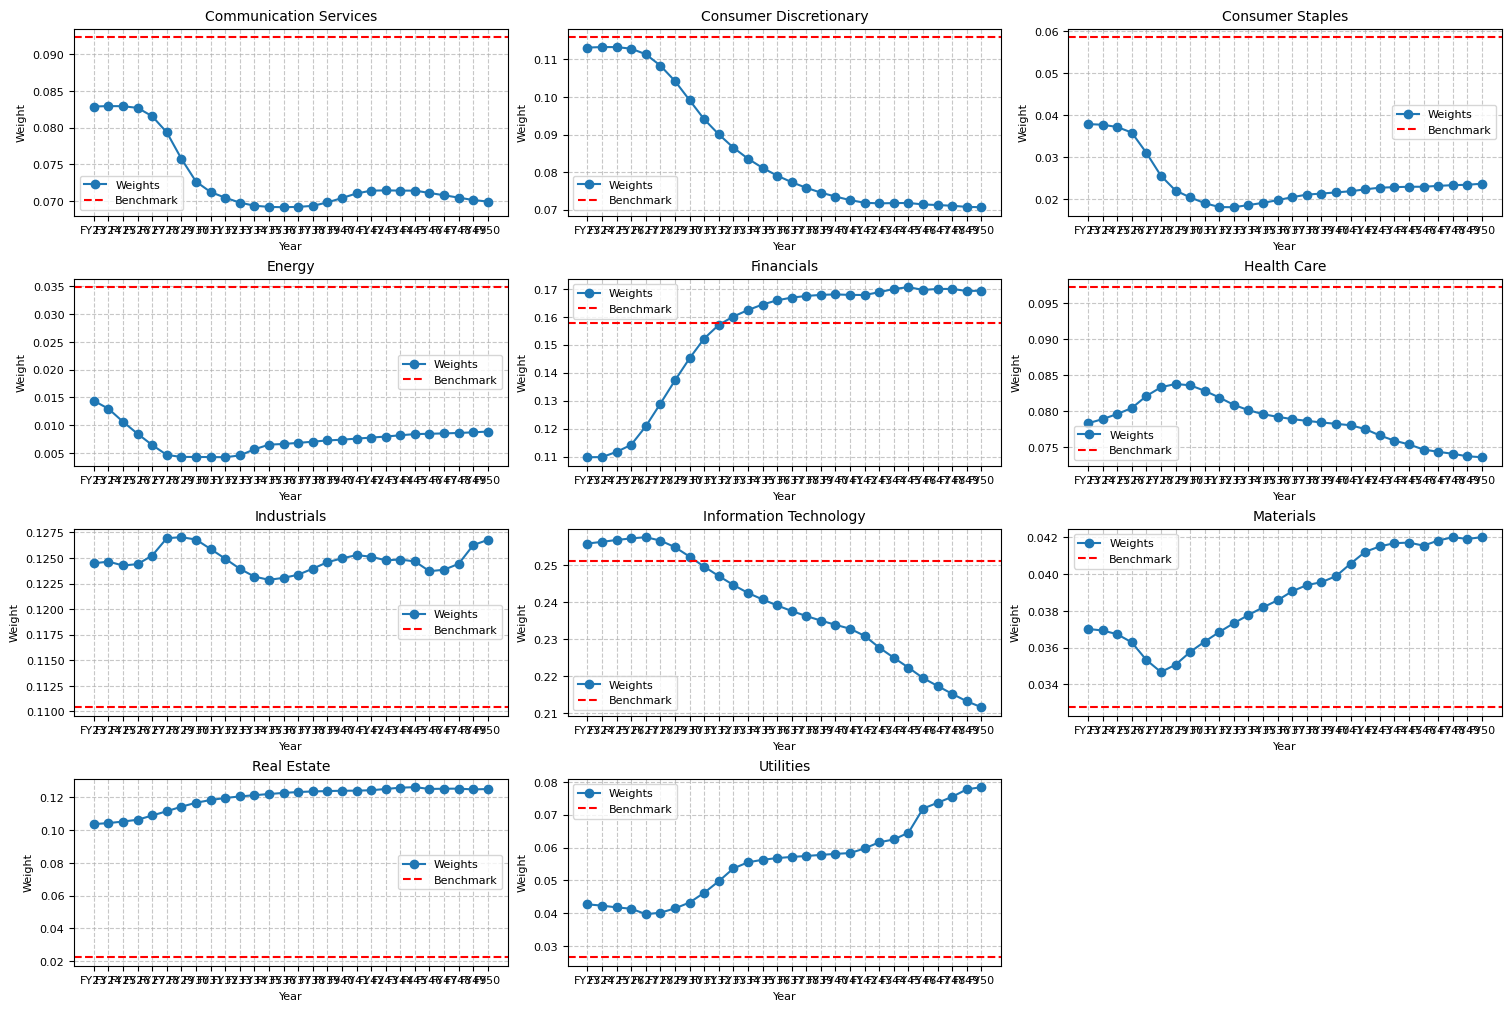

In [19]:
import math

# Extract the columns related to weights over the years
weight_columns = [col for col in CI.columns if col.startswith('Weight_G_FY')] 

# Group by sector and sum the weights for each year
sector_weights = CI.groupby('GICS_SECTOR')[weight_columns].sum()
benchmark_val = CI.groupby('GICS_SECTOR')["benchmark"].sum()

# Number of sectors
num_sectors = len(sector_weights.index)

# Define the number of columns for subplots (e.g., 3 columns per row)
cols = 3
rows = math.ceil(num_sectors / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot for each sector
for i, sector in enumerate(sector_weights.index):
    ax = axes[i]
    
    # Plot the weights over the years for the current sector
    ax.plot(
        [col.split('_')[-1] for col in weight_columns],  # Extract years from column names
        sector_weights.loc[sector],
        marker='o',
        label='Weights'
    )
    
    # Add a horizontal line for the benchmark value of the current sector
    ax.axhline(
        y=benchmark_val.loc[sector], 
        color='r', 
        linestyle='--', 
        label='Benchmark'
    )
    
    # Titles and labels
    ax.set_title(sector, fontsize=10)
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Weight', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

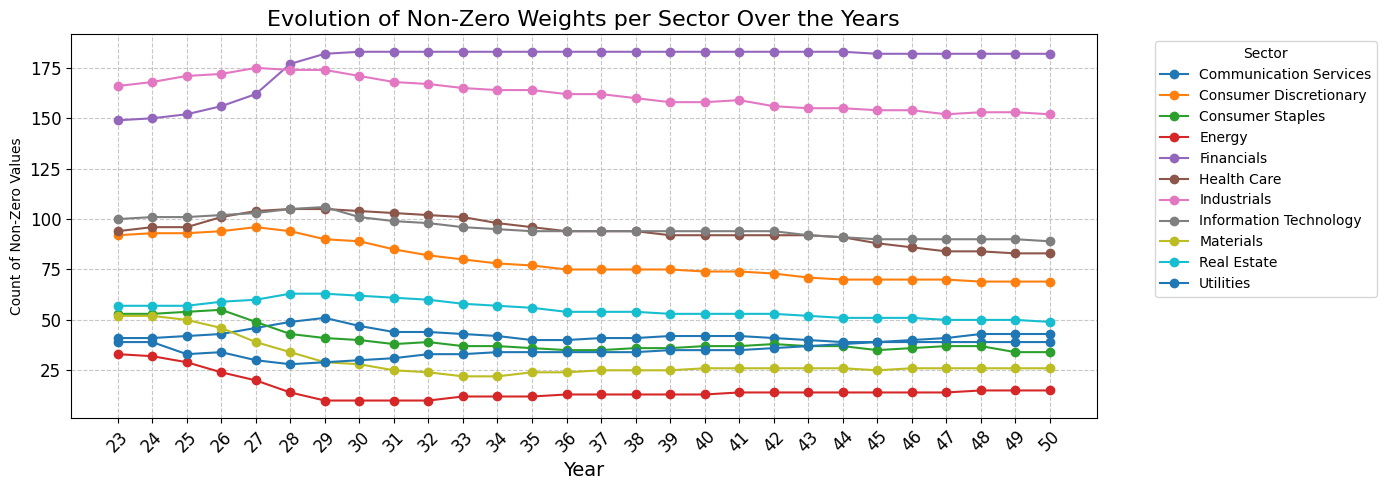

In [32]:
# Extraire les colonnes liées aux poids au fil des années
weight_columns = [col for col in CI.columns if col.startswith('Weight_G_FY')]

# Ajouter des colonnes "zero_" indiquant si les valeurs sont significativement différentes de zéro
for i, col in enumerate(weight_columns):
    CI[f"zero_{23 + i}"] = CI[col] > 0.00001
    1  # Ajuster l'index des années (par exemple, FY23 = 2023)

# Sélectionner les colonnes "zero_" pour le comptage
zero_columns = [col for col in CI.columns if col.startswith('zero_')]

# Grouper par secteur et compter les valeurs "True" pour chaque année
non_zero_counts = CI.groupby('GICS_SECTOR')[zero_columns].sum()

# Transposer pour visualiser les années sur l'axe X
non_zero_counts.T.plot(figsize=(14, 5), marker='o')

# Ajouter des titres, labels et personnalisation
plt.title('Evolution of Non-Zero Weights per Sector Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Non-Zero Values')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(
    ticks=range(len(zero_columns)), 
    labels=[col.split('_')[-1] for col in zero_columns], 
    rotation=45, 
    fontsize=12
)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


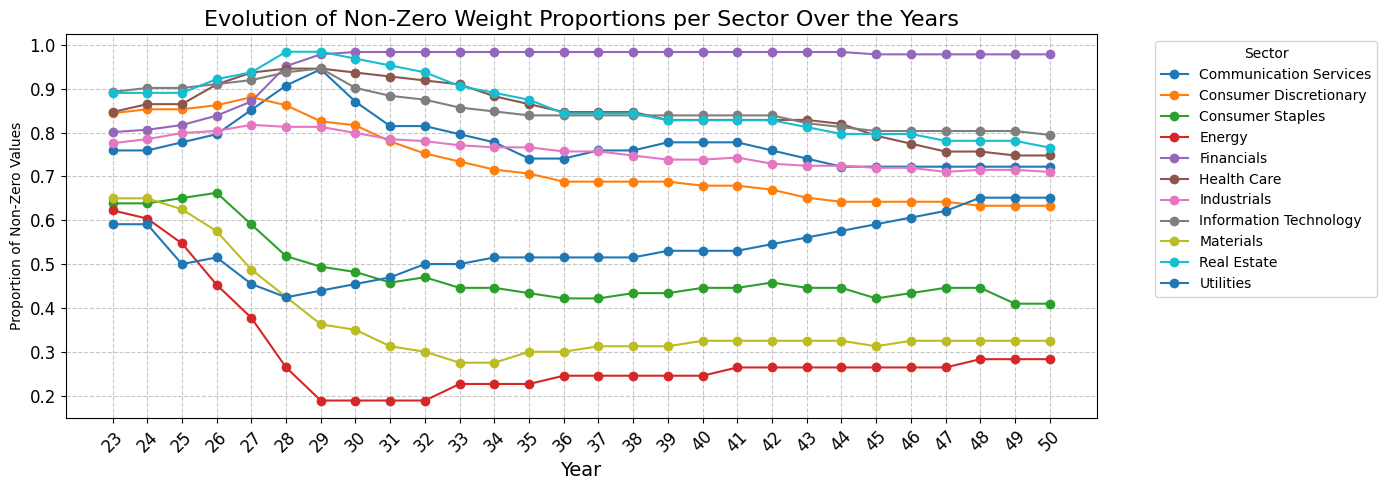

In [33]:
# Extraire les colonnes liées aux poids au fil des années
weight_columns = [col for col in CI.columns if col.startswith('Weight_G_FY')]

# Ajouter des colonnes "zero_" indiquant si les valeurs sont significativement différentes de zéro
for i, col in enumerate(weight_columns):
    CI[f"zero_{23 + i}"] = CI[col] > 0.00001  # Ajuster l'index des années (par exemple, FY23 = 2023)

# Sélectionner les colonnes "zero_" pour le comptage
zero_columns = [col for col in CI.columns if col.startswith('zero_')]

# Grouper par secteur et compter les valeurs "True" pour chaque année
sector_counts = CI.groupby('GICS_SECTOR')[zero_columns].sum()

# Calculer le nombre total de lignes par secteur
sector_totals = CI.groupby('GICS_SECTOR').size()

# Diviser chaque somme par le nombre de lignes du secteur pour obtenir les parts
sector_proportions = sector_counts.div(sector_totals, axis=0)

# Transposer pour visualiser les années sur l'axe X
sector_proportions.T.plot(figsize=(14, 5), marker='o')

# Ajouter des titres, labels et personnalisation
plt.title('Evolution of Non-Zero Weight Proportions per Sector Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Proportion of Non-Zero Values')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(
    ticks=range(len(zero_columns)), 
    labels=[col.split('_')[-1] for col in zero_columns], 
    rotation=45, 
    fontsize=12
)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


['Industrials' 'Energy' 'Consumer Discretionary' 'Consumer Staples'
 'Utilities' 'Financials' 'Materials' 'Communication Services'
 'Health Care' 'Information Technology' 'Real Estate']


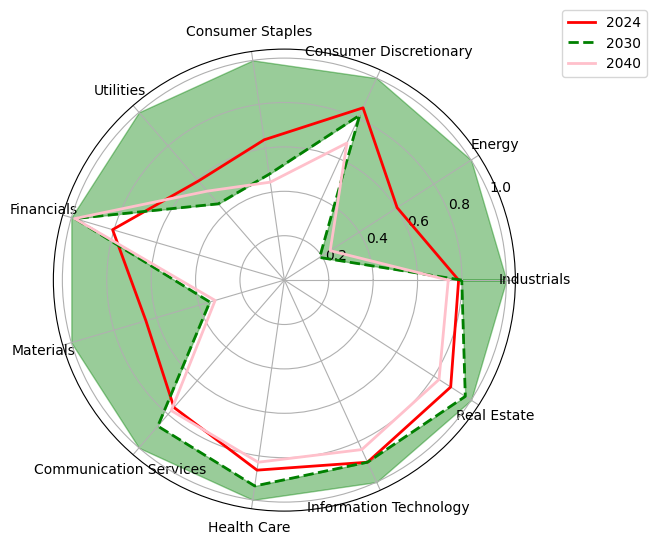

In [36]:
#liste des GICS_SECTOR
categories =  CI["GICS_SECTOR"].unique()
print(categories)

#valeurs des proportions pour l'année 2024 ie la valeur de la colonne zero_24
values24 = []
values30 = []
values40 = []
ones = []
for cat in categories:
    values24.append(sector_proportions.loc[cat]["zero_24"])
    values30.append(sector_proportions.loc[cat]["zero_30"])
    values40.append(sector_proportions.loc[cat]["zero_40"])
    ones.append(1)

    

N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
values24 += values24[:1]  # Idem pour les valeurs de l'année 2024
values30 += values30[:1]  # Idem pour les valeurs de l'année 2030
values40 += values40[:1]  # Idem pour les valeurs de l'année 2040
ones += ones[:1]
angles += angles[:1]  # Idem pour l'angle


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values24, color='red', linewidth=2,label="2024")  # Contour
ax.fill_between(angles, values30, ones, color='green', alpha=0.4)  # Surface remplie
ax.plot(angles, values30, color='green', linewidth=2,label="2030",linestyle='dashed')  # Contour
ax.plot(angles, values40, color='pink', linewidth=2,label="2040")  # Contour

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()
